<a href="https://colab.research.google.com/github/nverchev/BettingNetworks/blob/main/EfficientNet/BettingNetworksEfficient.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Betting Networks
This notebook is an implementation of Betting Networks, a classifier that uses adversarial learning. It comprises a baseline and evaluation metrics.

To save and load the model please have a look at the trainer cell.


In [ ]:
#!pip install --quiet optuna
!pip install "opencv-python-headless<4.3" #downgrading opencv in case of compatibility issues with albumentation
!pip install -q -U albumentations --quiet
!git clone https://github.com/nverchev/BettingNetworks.git
!mkdir ./BettingNetworks/EfficientNet/EfficientNet/
!wget http://storage.googleapis.com/public-models/efficientnet-b0-08094119.pth -O./BettingNetworks/EfficientNet/EfficientNet/efficientnet-b0-08094119.pth

--2022-01-10 15:42:41--  http://storage.googleapis.com/public-models/efficientnet-b0-08094119.pth
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.133.128, 74.125.140.128, 108.177.15.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.133.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21383481 (20M) [application/octet-stream]
Saving to: ‘./EfficientNet/efficientnet-b0-08094119.pth’

./EfficientNet/effi 100%[===================>]  20.39M  46.0MB/s    in 0.4s    

2022-01-10 15:42:42 (46.0 MB/s) - ‘./EfficientNet/efficientnet-b0-08094119.pth’ saved [21383481/21383481]

     |████████████████████████████████| 21.6 MB 63.4 MB/s 
     |████████████████████████████████| 102 kB 12.5 MB/s 


In [ ]:
#@title Libraries
import torch
import time
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import json
import re
from torch import optim
import torch.cuda.amp as amp
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from torchvision import datasets
from torch.utils.data.sampler import SubsetRandomSampler
from abc import ABCMeta,abstractmethod
import gc
from sklearn import metrics
import torchvision
from PIL import Image
from torchvision.datasets.cifar import CIFAR100 
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from torch.utils.data import DataLoader
from PIL.Image import BICUBIC
from collections import OrderedDict
#import optuna

In [ ]:
#@title Hyperparameters: { display-mode: "form" }
#@markdown "model_name" selects the model, "version" names different experiments. When "version = final" the model is trained on both training and validation dataset and tested on the test dataset.   
model_name = "BaselineClassifier"  #@param ['BaselineClassifier', 'BettingNetworks', 'BettingNetworksTwoHeaded', "BaselineClassifier_no_momentum", "BettingCrossEntropy"]
version = 'final' #@param {type: "string"}
batch_size =  64 #@param {type: "number"}
noised_label_perc =  0  # @param {type: "integer"}
assert 0 <= noised_label_perc < 100
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [ ]:
#@title Create Datasets
if 'dirpath' not in locals():
  dirpath = "./BettingNetworks/EfficientNet"
data_path = os.path.join(dirpath,'Cifar100')
Loader = True #@param {type:"boolean"}
def A_transform(transform):
  return lambda img: transform(image=np.array(img))['image']

train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.0, always_apply=True),
    A.Sharpen((0.1,0.2)),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    A.SmallestMaxSize(256, interpolation=2),
    A.Affine(shear=(-5,5)),
    A.ShiftScaleRotate(rotate_limit=10, p=0.5),
    A.RandomCrop(224,224),
    A.CoarseDropout(max_holes=1, max_height=56, max_width=56, p=0.3),
    ToTensorV2(),
])
test_transform = A.Compose([
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),                          
    A.SmallestMaxSize(224, interpolation=2),   
    A.pytorch.ToTensorV2(),
])
split = 1/6
pin_memory=torch.cuda.is_available()

train_dataset = CIFAR100(root=data_path, train=True, transform=A_transform(train_transform), download=Loader)
val_dataset =  CIFAR100(root=data_path, train=True, transform=A_transform(test_transform), download=False)
test_dataset = CIFAR100(root=data_path, train=False, transform=A_transform(test_transform), download=Loader)

num_train = len(train_dataset)
split = int(np.floor(split * num_train))
indices = list(range(num_train))
train_idx, valid_idx = indices[split:], indices[:split]    
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# adding noise to targets during training
if noised_label_perc > 0:
  np.random.seed = 123 
  jump = 100 // noised_label_perc
  for i in range(0, len(train_dataset), jump):
    train_dataset.targets[i] = np.random.randint(100)
    
# class umbalanced
if version == "class_imbalanced":
  for i in range(len(train_dataset)):
    train_dataset.targets[i] = min(50, train_dataset.targets[i])
  for i in range(len(test_dataset)):
    test_dataset.targets[i] = min(50, test_dataset.targets[i])

train_loader = torch.utils.data.DataLoader(train_dataset, 
    batch_size=batch_size, sampler=train_sampler, drop_last=True, pin_memory=pin_memory)

val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, sampler=valid_sampler, pin_memory=pin_memory
)
train_val_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, drop_last=True, pin_memory=pin_memory
)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, 
                                          shuffle=False, pin_memory=pin_memory)



  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting ./BettingNetworks/EfficientNet/Cifar100/cifar-100-python.tar.gz to ./BettingNetworks/EfficientNet/Cifar100
Files already downloaded and verified


In [ ]:
#@title Block Args
initial_learning_rate = 0.01 if model_name == "BaselineClassifier" else 0.02
weight_decay = 0.001

class ExponentialSchedule:
    def __init__(self, exp_decay = .975):
        self.exp_decay = exp_decay

    def __call__(self, base_lr, epoch):
        return base_lr*self.exp_decay**epoch

    def __repr__(self):
        return  "ExponentialSchedule"

class CosineSchedule:
    def __init__(self, decay_steps = 60, min_decay = 0.1):
        self.decay_steps = decay_steps
        self.min_decay = min_decay

    def __call__(self, base_lr, epoch):
        min_lr = self.min_decay * base_lr
        return min_lr + (base_lr - min_lr) * (1 + np.cos(np.pi * epoch/self.decay_steps)/ 2)

    def __repr__(self):
        return  "CosineSchedule"

momentum = 0.9 if model_name == "BaselineClassifier" else 0
nesterov = model_name == "BaselineClassifier"
opt = 'SGD'
optimizer= { 'Adam': optim.Adam,
             'SGD': optim.SGD,
            'AdamW': optim.AdamW
    }
def helper_lr(base_learning_rate):
  lr = {}
  lr['stem'] = base_learning_rate * 0.1
  lr['blocks'] = base_learning_rate * 0.1
  
  if model_name in ["BaselineClassifier","BaselineClassifier_no_momentum"]:
      lr['head'] = base_learning_rate * 0.2
      lr['classifier'] = base_learning_rate
  elif model_name in ["BettingNetworks", "BettingCrossEntropy"]:
      lr['head'] = base_learning_rate * 0.2
      lr['book'] = base_learning_rate
      lr['bettor'] = base_learning_rate
  elif model_name == "BettingNetworksTwoHeaded":
      lr['head1'] = base_learning_rate * 0.2
      lr['head2'] = base_learning_rate * 0.2
      lr['book'] = base_learning_rate
      lr['bettor'] = base_learning_rate
  return lr


lr = helper_lr(initial_learning_rate) 

# those args will be later overwritten in favour of finetuning
optimi_args = {'Adam': {'weight_decay':weight_decay, 'lr': lr},
               'SGD' : {'weight_decay':weight_decay, 'lr': lr,
                        'momentum': momentum, 'nesterov':nesterov},
               'AdamW': {'weight_decay':weight_decay, 'lr': lr},
}



train_loader = train_loader if version[:5]!= 'final' else train_val_loader
val_loader = val_loader if version[:5]!= 'final' else None
block_args={
    'optim_name': opt,
    'optim': optimizer[opt],
    'optim_args': optimi_args[opt],    
    'train_loader': train_loader,
    'device': device,
    'val_loader':  val_loader,
    'test_loader': test_loader,
    'batch_size': batch_size,
    'schedule': CosineSchedule()
    }
for k,v in block_args.items():
  if not isinstance(v,(type,torch.utils.data.dataloader.DataLoader)):
    print(k, ': ', v)

optim_name :  SGD
optim_args :  {'weight_decay': 0.001, 'lr': {'stem': 0.002, 'blocks': 0.002, 'head1': 0.004, 'head2': 0.004, 'book': 0.02, 'bettor': 0.02}, 'momentum': 0, 'nesterov': False}
device :  cuda:0
val_loader :  None
batch_size :  64
schedule :  CosineSchedule


In [ ]:
#@title Trainer
'''
This abstract class manages training and general utilites.
It works together with a class defining the loss.
This loss returns a dictionary dict with 
dict["Criterion"] = *list of losses to backprop*
'''

class Trainer(metaclass=ABCMeta):
    losses = [] # defiend later with the loss function
    hypertuning_mode = False # less output
    max_output = np.inf #maximum amount of stored evaluated test samples
    dirpath = dirpath 
    miniopath = staticmethod(lambda path: path[len(dirpath):]) #removes dirpath 

    def __init__(self,model,version,device,optim,train_loader,val_loader=None,
                 test_loader=None, mp=False,**block_args):
        
        torch.manual_seed = 112358
        self.epoch = 0
        self.device = device # to cuda or not to cuda?
        self.model = model.to(device) # model is not copied
        self.version = version # name used for saving and loading  
        self.schedule = block_args['schedule']
        self.settings = {**model.settings,**block_args,'Optimizer':str(optim)}
        self.optimizer_settings = block_args['optim_args'].copy()
        self.optimizer = optim(**self.optimizer_settings)
        self.mp = mp and device.type == 'cuda' # mixed precision casting
        self.scaler = amp.GradScaler(enabled=mp) # mixed precision backpropa
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.train_losses = {loss:[] for loss in self.losses}
        self.val_losses = {loss:[] for loss in self.losses}
        self.test_losses = {loss:[] for loss in self.losses}
        self.test_targets,self.test_outputs = [], {}
        self.converge = 1 # if 0 kills session

    @property
    def optimizer_settings(self): #settings shown depend on epoch 
        if self.schedule is None:   
          return {'params':self._optimizer_settings[0],
                  **self._optimizer_settings[1]}
        else: # the scheduler modifies the learning rate(s)
          init_learning = self._optimizer_settings[0]
          sheduled_learning = []
          for group in init_learning:
            sheduled_learning.append({
                                      'params': group['params'],
                                      'lr': self.schedule(group['lr'],self.epoch)
                                      })
          return  {'params':sheduled_learning, 
                   **self._optimizer_settings[1]}
 

    @optimizer_settings.setter
    def optimizer_settings(self, optim_args):
        lr = optim_args.pop('lr')
        if isinstance(lr,dict):
            self._optimizer_settings = [
                            {'params': getattr(self.model,k).parameters(),
                              'lr':v} for k,v in lr.items()], optim_args
        else:
            self._optimizer_settings = \
                            [{'params':model.parameters(),'lr':lr}],optim_args
        return        


    def update_learning_rate(self, new_lr):
        if not isinstance(new_lr,list): # transform to list
          new_lr = [{'lr':new_lr} for _ in self.optimizer.param_groups]
        for g, up_g in zip(self.optimizer.param_groups, new_lr):
                g['lr'] = up_g['lr']
        return


    def train(self, num_epoch, val_after_train = False):
        print('Version ',self.version)
        for _ in range(num_epoch):
            self.update_learning_rate(self.optimizer_settings['params'])
            self.epoch += 1
            print('====> Epoch:{}'.format(self.epoch))        
            self._run_session(mode='train')
            if self.val_loader and val_after_train: #check losses on val
              self._run_session(mode='val')         #best to test instead
        return
  

    def test(self, on = 'val'): #runs and stores evaluated test samples
        print('Version ',self.version)
        self.test_targets,self.test_outputs = \
            self._run_session(mode=on, save_outputs=True) #stored in RAM
        return

    def _run_session(self, mode='train', save_outputs=False, max_output=None):
        if mode == 'train':
            self.model.train()
            torch.set_grad_enabled(True)
            loader=self.train_loader
            dict_losses= self.train_losses           
        elif mode == 'val':
            self.model.eval()
            torch.set_grad_enabled(False)
            loader = self.val_loader
            dict_losses= self.val_losses
        elif mode == 'test':
            self.model.eval()
            torch.set_grad_enabled(False)
            loader = self.test_loader
            dict_losses = self.test_losses
        else:
            raise ValueError('mode options are: "train", "val", "test" ')
        if save_outputs:
            test_targets,test_outputs = [], {}

        len_sess = len(loader.dataset)
        epoch_loss = {loss:0 for loss in  self.losses}
        num_batch = len(loader)
        iterable = enumerate(loader) if self. hypertuning_mode else \
                             tqdm(enumerate(loader),total=num_batch) 
        for batch_idx, (inputs, targets) in iterable:
            if self.converge == 0:
              return 
            inputs, targets = self.to_recursive([inputs,targets],device)
            inputs_aux = self.helper_inputs(inputs,targets)
            with amp.autocast(self.mp):
                outputs =  self.model(**inputs_aux)
                batch_loss = self.loss(outputs, inputs, targets)
            criterion = batch_loss.pop('Criterion')
            for loss in self.losses:
               epoch_loss[loss] += batch_loss[loss].item()
            if  mode == 'train':
              for lss in criterion:
                if torch.isinf(lss) or torch.isnan(lss):
                  self.converge=0
                self.scaler.scale(lss).backward()
              self.scaler.step(self.optimizer)
              self.scaler.update()
              self.optimizer.zero_grad()
            if save_outputs and \
                   self.max_output > (batch_idx + 1) * loader.batch_size:
              self.extend_dict_list(
                  test_outputs, self.to_recursive(outputs,'detach_cpu'))
              test_targets.extend(self.to_recursive(targets,'detach_cpu'))
            if not self.hypertuning_mode and mode=='train':
                if batch_idx % (len(loader)//10 or 1) == 0:
                    iterable.set_description(
                                    'Train [{:4d}/{:4d} ]\tLoss {:4f}'.format(
                                                batch_idx * loader.batch_size,
                                                len_sess,
                                                criterion[0].item())
                                            )
                if batch_idx == len(loader)-1: # clear after last
                    iterable.set_description('') 

        for loss in self.losses:
          epoch_loss[loss] /= num_batch
          if not save_outputs: #do not save history when testing
              dict_losses[loss].append(epoch_loss[loss])
        if not self.hypertuning_mode:
          print('Average {} losses :'.format(mode))
          for loss in self.losses:
              print('{}: {:.4f}'.format(loss,epoch_loss[loss]), end='\t')
          print()
        if save_outputs:
          return  test_targets,test_outputs
        else:
          return
        
    def helper_inputs(self,inputs,labels):
        return {'x' : inputs}

    def plot_losses(self, loss):
        tidy_loss = " ".join([s.capitalize() for s in loss.split('_')])
        epochs=np.arange(self.epoch)
        plt.plot(epochs, self.train_losses[loss], label='train')
        if self.val_loader:
          plt.plot(epochs, self.val_losses[loss], label='val')
        plt.xlabel('Epochs')
        plt.ylabel(tidy_loss)
        plt.title(f"{self.version}")
        plt.show()
        return

    @staticmethod
    def to_recursive(obj, device): #changes device in dictionary and lists
      if isinstance(obj, list):
        obj = [Trainer.to_recursive(item, device) for item in obj]
      elif isinstance(obj, dict):
        obj = {k: Trainer.to_recursive(v, device) for k,v in obj.items()}
      else:
        try: 
          obj=obj.detach().cpu() if device == 'detach_cpu' else  obj.to(device)
        except AttributeError:
          raise ValueError(f'Datatype {type(obj)} does not contain tensors')
      return obj

    @staticmethod #extends lists in dictionaries
    def extend_dict_list(old_dict, new_dict):
      for key,value in new_dict.items():         
          if key not in old_dict.keys():
            old_dict[key]=[]
            if isinstance(value,list):
              for elem in value:
                old_dict[key].append([])
          if isinstance(value,list):
            for elem, new_elem in zip( old_dict[key],value):
              elem.extend(new_elem)
          else: 
            old_dict[key].extend(value)
    
    @staticmethod #indexes a list (inside of a list) inside of a dictionary
    def index_dict_list(dict_list,ind):
      list_dict = {}
      for k, v in dict_list.items():
        if len(v) == 0 or isinstance(v[0],list):
          new_v = []
          for elem in v:
            new_v.append(elem[ind].unsqueeze(0))
        else:
          new_v = v[ind].unsqueeze(0)
        list_dict[k] = new_v
      return list_dict

    @abstractmethod
    def loss(self,output, inputs, targets):
        pass

    def save(self,new_version=None):
        self.model.eval()
        paths=self.paths(new_version)
        torch.save(self.model.state_dict(),paths['model'])
        torch.save(self.optimizer.state_dict(),paths['optim'])
        json.dump(self.train_losses, open(paths['train_hist'], 'w'))
        json.dump(self.val_losses, open(paths['val_hist'], 'w'))
        return
    
    def load(self, epoch=None):
        directory=self.version
        
        if epoch is not None:
          self.epoch = epoch
        else:
          past_epochs = [] #here it looks for the most recent model
          local_path = os.path.join(self.dirpath,self.version)
          if os.path.exists(local_path):
              for file in os.listdir(local_path):
                if file[:5]=='model':
                      past_epochs.append(int(re.sub("\D", "",file)))
          if len(past_epochs) == 0:
            print("No saved models found")
            return
          else:
              self.epoch = max(past_epochs)
        paths = self.paths()
        self.model.load_state_dict(torch.load(paths['model'],
                                  map_location=torch.device(self.device)))        
        self.optimizer.load_state_dict(torch.load(paths['optim'],
                                      map_location=torch.device(self.device)))
        self.train_losses = json.load(open(paths['train_hist']))
        self.val_losses = json.load(open(paths['val_hist']))
        print("Loaded: ",paths['model'])
        return

    def paths(self,new_version=None):
        if new_version: # save a parallel version to work with
          directory = os.path.join(self.dirpath,new_version)
          id = self.epoch
        else:
          directory = os.path.join(self.dirpath,self.version)
          id = self.epoch
        if not os.path.exists(directory):
            os.mkdir(directory)
        paths = {}
        paths['model'] = os.path.join(directory,f'model_epoch{id}.pt')
        paths['optim'] = os.path.join(directory,f'optimizer_epoch{id}.pt')
        paths['train_hist'] = os.path.join(directory,'train_losses.json')
        paths['val_hist'] = os.path.join(directory,'val_losses.json')
        return paths


In [ ]:
#@title Metrics
class ClassificationMetrics():
    _metrics = {}
    wrong_indices = []
    average = "macro"
    
    #overwrites Trainer method
    def test(self, run=True, on='test', prob = 'book'):
      print('Version ',self.version)
      if run:
          self.test_targets,self.test_outputs = \
                self._run_session(mode=on, save_outputs=True) #stored in RAM 
      if prob == 'book': #standard or book probabilities
        self.test_probs = torch.stack(self.test_outputs['probs'])
      elif 'q' not in self.test_outputs.keys():
        print('Bettor probabilities not available')
        return
      elif prob == 'bettor': #bettor probabilities
        self.test_probs = torch.stack(self.test_outputs['q'])
      elif prob == 'mean':
        q = torch.stack(self.test_outputs['q'])
        probs = torch.stack(self.test_outputs['q'])
        self.test_probs = (q + probs)/2
      else:
        print('prob = '+ prob + ' not defined') 
        return       
      self.test_pred = torch.argmax(self.test_probs, dim = 1)
      self.targets = torch.stack(self.test_targets)
      right_pred = (self.test_pred == self.targets)
      self.wrong_indices = torch.nonzero(~right_pred)
      self.calculate_metrics()
      return

    @property
    def metrics(self):
        self.test(on = 'val')
        return self._metrics

    def calculate_metrics(self, print_flag=True):

        avg_type = self.average.capitalize() + ' ' if self.test_probs.size(1) > 1 else ""
        #calculates common and also gives back the indices of the wrong guesses   

        self._metrics['Accuracy'] = \
              metrics.accuracy_score(self.targets,self.test_pred)
        self._metrics[avg_type + 'F1 Score'] = \
              metrics.f1_score(self.targets,self.test_pred,average=self.average)
        self._metrics[avg_type + 'Jaccard Score'] = \
              metrics.jaccard_score(self.targets,
                                    self.test_pred,average=self.average)
        self._metrics[avg_type + 'AUC ROC'] = \
              metrics.roc_auc_score(self.targets,self.test_probs,
                                 average=self.average,multi_class='ovr')
        if print_flag:
          for metric, value in self._metrics.items():
            print( metric + f' : {value:.4f}', end = '\t' )
          print('')
        return
    

class Analysis():
    '''
    We consider here only the probability for the most likely class 
    (the max probability) as it is the more interesting for prediction.
    '''

    def prob_analysis(self,on='val', bins=100, prob='book'): #call after test
        self.bins = bins
        print(self.version)
        if self.wrong_indices == []:
          self.test(on=on, prob=prob)
        self.uniform_calibration_prediction()
        self.uniform_calibration()
        self.quantile_calibration_prediction()
        self.quantile_calibration()

    def uniform_calibration_prediction(self):
        confidence = np.linspace(1/(2*self.bins), 1-1/(2*self.bins), self.bins)
        highest_conf = torch.max(self.test_probs, dim = 1)[0]
        wrong_conf = highest_conf[self.wrong_indices]
        hist = torch.histc(highest_conf, bins=self.bins, min=0, max=1)
        wrong_hist = torch.histc(wrong_conf, bins=self.bins, min=0, max=1)
        right_hist = hist - wrong_hist

        # Empty bins are given expected probabability
        obs_prob = np.divide(right_hist, hist,\
                out=np.zeros(self.bins), where=hist!=0)
        print('Max confidence')
        plt.figure(figsize=(30,6))
        plt.subplot(1, 4, 1)
        plt.bar(confidence, hist/hist.sum(), width=.9/self.bins)
        plt.xticks(np.linspace(0,1,5),np.linspace(0,1,5))
        plt.title('max confidendence distribution')

        plt.subplot(1, 4, 2)
        plt.bar(confidence, wrong_hist/wrong_hist.sum(), width=.9/self.bins)
        plt.title('missclassified by conf (normalized)')
        plt.xticks(np.linspace(0,1,5),np.linspace(0,1,5))

        plt.subplot(1, 4, 3)
        plt.bar(confidence, right_hist/right_hist.sum(), width=.9/self.bins)
        plt.title('correct by conf (normalized)')
        plt.xticks(np.linspace(0,1,5),np.linspace(0,1,5))
        
        plt.subplot(1, 4, 4)
        plt.title('frequentist probability by conf')
        plt.bar(confidence, obs_prob, width=.9/self.bins)
        plt.xticks(np.linspace(0,1,5),np.linspace(0,1,5)) 
        plt.plot(np.linspace(0,1,self.bins),np.linspace(0,1,self.bins),color='seagreen')
        plt.show()
        
        nonzero = np.nonzero(hist)
        ece = np.abs(obs_prob[nonzero]-confidence[nonzero]).mean()
        print('ECE_pred: ', ece.item())
        
    def uniform_calibration(self): 
        confidence = np.linspace(1/(2*self.bins), 1-1/(2*self.bins), self.bins)  
        ece = 0
        for cls in range(self.model.num_classes):
          conf = self.test_probs[:,cls]
          right_indices = torch.nonzero(self.targets==cls)
          right_conf = conf[right_indices]
          hist = torch.histc(conf, bins=self.bins, min=0, max=1)
          right_hist = torch.histc(right_conf, bins=self.bins, min=0, max=1)
          wrong_hist = hist - right_hist
          nonzero = np.nonzero(hist)
          obs_prob = np.divide(right_hist, hist, where=hist!=0)
          ece += torch.abs(obs_prob[nonzero]-confidence[nonzero]).mean()

        targets = F.one_hot(self.targets, num_classes=self.model.num_classes).float()
        brier_multi = torch.mean(torch.sum((self.test_probs - targets)**2, axis=1))
        print('ECE: ', (ece/self.model.num_classes).item(), ' Brier Score: ', brier_multi.item())
        return

    def quantile_calibration_prediction(self):
        highest_conf = torch.max(self.test_probs, dim = 1)[0]
        right_conf = torch.ones_like(highest_conf)
        right_conf[self.wrong_indices] =  0
        confidence, obs_prob = self.quantile_binning(highest_conf, right_conf, self.bins)
        print('Max conf quantile')
        plt.figure(figsize=(30,6))
        plt.subplot(1, 2, 1)
        plt.title('frequentist probability by conf')
        plt.bar(confidence, obs_prob, width=.9/self.bins)
        plt.xticks(np.linspace(0,1,5),np.linspace(0,1,5))
        plt.plot(np.linspace(0,1,self.bins),np.linspace(0,1,self.bins), color="seagreen")
        plt.subplot(1, 2, 2)
        plt.title('frequentist probability by conf (remapped)')
        plt.bar(np.linspace(0,1,self.bins), obs_prob, width=.9/self.bins)
        plt.xticks(np.linspace(0,1,5),[round(confidence[i].item(),2) for i in range(0, self.bins, self.bins//5)])
        plt.plot(np.linspace(0,1,self.bins),confidence, color="seagreen")
        plt.show()

        ece = np.abs(obs_prob - confidence).mean()
        print('Quantile ECE_pred: ', ece.item())
        return

    def quantile_calibration(self):
        ece = 0
        for cls in range(self.model.num_classes):
          conf = self.test_probs[:,cls]
          right_conf = (self.targets==cls).float()
          confidence, obs_prob = self.quantile_binning(conf, right_conf, self.bins)
          ece += np.abs(obs_prob - confidence).mean()
        print('Quantile ECE: ', (ece/self.model.num_classes).item())
        return


    @staticmethod
    def quantile_binning(conf, targets, bins):
        conf, order = conf.sort()
        targets = targets[order]
        tensor = torch.vstack([conf, targets]).t()
        N = tensor.size(0)
        N_bins_float = N/(bins)
        assert N_bins_float >= 1
        N_bin = int(N_bins_float)
        larger_bins = N - N_bin * bins
        smaller_bins = bins - larger_bins
        avg_conf, avg_corr = [], []
        for t in tensor.split(larger_bins * [N_bin+1] + smaller_bins * [N_bin]):
            aconf, acorr = t.mean(axis=0)
            avg_conf.append(aconf)
            avg_corr.append(acorr)
        return torch.stack(avg_conf), torch.stack(avg_corr)

In [ ]:
#@title Utils, Layers and Blocks

class Swish(nn.Module):
    
    def forward(self, x):
        return x * torch.sigmoid(x)

class Flatten(nn.Module):
    
    def forward(self, x):
        return x.flatten(1)

class SqueezeExcitation(nn.Module):
    
    def __init__(self, inplanes, se_planes):
        super(SqueezeExcitation, self).__init__()
        self.reduce_expand = nn.Sequential(
            nn.Conv2d(inplanes, se_planes, 
                      kernel_size=1, stride=1, padding=0, bias=True),
            Swish(),
            nn.Conv2d(se_planes, inplanes, 
                      kernel_size=1, stride=1, padding=0, bias=True),
            nn.Sigmoid()
        )

    def forward(self, x):
        x_se = torch.mean(x, dim=(-2, -1), keepdim=True)
        x_se = self.reduce_expand(x_se)
        return x_se * x
from torch.nn import functional as F


class MBConv(nn.Module):

    def __init__(self, inplanes, planes, kernel_size, stride, 
                 expand_rate=1.0, se_rate=0.25, 
                 drop_connect_rate=0.2):
        super(MBConv, self).__init__()

        expand_planes = int(inplanes * expand_rate)
        se_planes = max(1, int(inplanes * se_rate))

        self.expansion_conv = None        
        if expand_rate > 1.0:
            self.expansion_conv = nn.Sequential(
                nn.Conv2d(inplanes, expand_planes, 
                          kernel_size=1, stride=1, padding=0, bias=False),
                nn.BatchNorm2d(expand_planes, momentum=0.01, eps=1e-3),
                Swish()
            )
            inplanes = expand_planes

        self.depthwise_conv = nn.Sequential(
            nn.Conv2d(inplanes, expand_planes,
                      kernel_size=kernel_size, stride=stride, 
                      padding=kernel_size // 2, groups=expand_planes,
                      bias=False),
            nn.BatchNorm2d(expand_planes, momentum=0.01, eps=1e-3),
            Swish()
        )

        self.squeeze_excitation = SqueezeExcitation(expand_planes, se_planes)
        
        self.project_conv = nn.Sequential(
            nn.Conv2d(expand_planes, planes, 
                      kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(planes, momentum=0.01, eps=1e-3),
        )

        self.with_skip = stride == 1
        self.drop_connect_rate = drop_connect_rate
    
    def _drop_connect(self, x):        
        keep_prob = 1.0 - self.drop_connect_rate
        drop_mask = torch.rand(x.shape[0], 1, 1, 1) + keep_prob
        drop_mask = drop_mask.type_as(x)
        drop_mask.floor_()
        return drop_mask * x / keep_prob
        
    def forward(self, x):
        z = x
        if self.expansion_conv is not None:
            x = self.expansion_conv(x)

        x = self.depthwise_conv(x)
        x = self.squeeze_excitation(x)
        x = self.project_conv(x)
        
        # Add identity skip
        if x.shape == z.shape and self.with_skip:            
            if self.training and self.drop_connect_rate is not None:
                x = self._drop_connect(x)
            x += z
        return x
  

In [ ]:
#@title EfficientNet
def init_weights(module):    
    if isinstance(module, nn.Conv2d):    
        nn.init.kaiming_normal_(module.weight, a=0, mode='fan_out')
    elif isinstance(module, nn.Linear):
        init_range = 1.0 / math.sqrt(module.weight.shape[1])
        nn.init.uniform_(module.weight, a=-init_range, b=init_range)
        
        
class EfficientNet(nn.Module):
        
    def _setup_repeats(self, num_repeats):
        return int(math.ceil(self.depth_coefficient * num_repeats))
    
    def _setup_channels(self, num_channels):
        num_channels *= self.width_coefficient
        new_num_channels = math.floor(num_channels / self.divisor + 0.5) * self.divisor
        new_num_channels = max(self.divisor, new_num_channels)
        if new_num_channels < 0.9 * num_channels:
            new_num_channels += self.divisor
        return new_num_channels

    def __init__(self, num_classes=100, 
                 width_coefficient=1.0,
                 depth_coefficient=1.0,
                 se_rate=0.25,
                 dropout_rate=0.2,
                 drop_connect_rate=0.2,
                 list_channels = [32, 16, 24, 40, 80, 112, 192, 320, 1280]):
        super(EfficientNet, self).__init__()
        self.settings = {}
        self.width_coefficient = width_coefficient
        self.depth_coefficient = depth_coefficient
        self.divisor = 8
        self.num_classes = num_classes
                
        
        list_channels = [self._setup_channels(c) for c in list_channels]

        list_num_repeats = [1, 2, 2, 3, 3, 4, 1]
        list_num_repeats = [self._setup_repeats(r) for r in list_num_repeats]        
        
        expand_rates = [1, 6, 6, 6, 6, 6, 6]
        strides = [1, 2, 2, 2, 1, 2, 1]
        kernel_sizes = [3, 3, 5, 3, 5, 5, 3]

        # Define stem:
        self.stem = nn.Sequential(
            nn.Conv2d(3, list_channels[0], kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(list_channels[0], momentum=0.01, eps=1e-3),
            Swish()
        )
        
        # Define MBConv blocks
        blocks = []
        counter = 0
        num_blocks = sum(list_num_repeats)
        for idx in range(7):
            
            num_channels = list_channels[idx]
            next_num_channels = list_channels[idx + 1]
            num_repeats = list_num_repeats[idx]
            expand_rate = expand_rates[idx]
            kernel_size = kernel_sizes[idx]
            stride = strides[idx]
            drop_rate = drop_connect_rate * counter / num_blocks
            
            name = "MBConv{}_{}".format(expand_rate, counter)
            blocks.append((
                name,
                MBConv(num_channels, next_num_channels, 
                       kernel_size=kernel_size, stride=stride, expand_rate=expand_rate, 
                       se_rate=se_rate, drop_connect_rate=drop_rate)
            ))
            counter += 1
            for i in range(1, num_repeats):                
                name = "MBConv{}_{}".format(expand_rate, counter)
                drop_rate = drop_connect_rate * counter / num_blocks                
                blocks.append((
                    name,
                    MBConv(next_num_channels, next_num_channels, 
                           kernel_size=kernel_size, stride=1, expand_rate=expand_rate, 
                           se_rate=se_rate, drop_connect_rate=drop_rate)                                    
                ))
                counter += 1
        
        self.blocks = nn.Sequential(OrderedDict(blocks))
        
        self.head_gen = lambda: nn.Sequential(
                                      nn.Conv2d(list_channels[-2], list_channels[-1], 
                                                kernel_size=1, bias=False),
                                      nn.BatchNorm2d(list_channels[-1], momentum=0.01, eps=1e-3),
                                      Swish(),
                                      nn.AdaptiveAvgPool2d(1),
                                      Flatten()
                                  )
        self.classifier_gen = lambda: nn.Sequential(nn.Dropout(p=dropout_rate),
                                      nn.Linear(list_channels[-1], num_classes)
                                  )

        self.apply(init_weights)


    def forward(self, x):
        x = self.stem(x)
        x = self.blocks(x)
        return x

class BaselineClassifier(EfficientNet):

    def __init__(self,**kwargs):
        super().__init__(**kwargs)
        self.head = self.head_gen()
        self.classifier = self.classifier_gen()

    def forward(self, x):
        x = super().forward(x)
        x = self.head(x)        
        y = self.classifier(x)
        return {'y' : y,
                'probs': F.softmax(y,dim=1)}



class BettingNetworks(EfficientNet):

    def __init__(self,**kwargs):
        super().__init__(**kwargs)
        self.head = self.head_gen()
        self.book = self.classifier_gen()
        self.bettor = self.classifier_gen()

    def forward(self, x):
        x = super().forward(x)
        x = self.head(x)        
        hidden = x.detach().clone()
        y = self.book(x)
        p = F.softmax(y,dim=1)  
        yhat = self.bettor(hidden)
        q = F.softmax(yhat,dim=1)
        return {'y': y,
                'yhat': yhat,
                'probs': p,
                'q': q
                } 

class BettingNetworksTwoHeaded(EfficientNet):

    def __init__(self,**kwargs):
        super().__init__(**kwargs)
        self.head1 = self.head_gen()
        self.book = self.classifier_gen()
        self.head2 = self.head_gen()
        self.bettor = self.classifier_gen()

    def forward(self, x):
        x = super().forward(x)
        detached = x.detach().clone()
        x = self.head1(x)
        y = self.book(x)
        p = F.softmax(y,dim=1)
        x = self.head2(detached)
        yhat = self.bettor(x)
        q = F.softmax(yhat,dim=1)
        return {'y': y,
                'yhat': yhat,
                'probs': p,
                'q': q
                }
model_class = {"BaselineClassifier" : BaselineClassifier,
               "BettingNetworks" : BettingNetworks,
               "BettingNetworksTwoHeaded": BettingNetworksTwoHeaded,
               "BettingCrossEntropy": BettingNetworks,
               "BaselineClassifier_no_momentum": BaselineClassifier,
              }
num_classes = 50 if version == "class_imbalanced" else 100
  
model = model_class[model_name](num_classes=num_classes) 


In [ ]:
#@title Losses

class CELoss():
    losses=['CE']
    def loss(self, output, inputs, targets):
        y = output['y']
        CE = F.cross_entropy(y,targets) 
        return {'Criterion':[CE],
                'CE':CE}

class MSELoss():

    losses=['MSE']
    def loss(self, output, inputs, targets):
        probs = output['probs']
        targets = F.one_hot(targets, num_classes=self.model.num_classes).float()
        MSE = F.mse_loss(probs,targets) 
        _MSE = ((targets-probs)**2).sum()
        return {'Criterion':[MSE],
                'MSE':MSE,
                '_MSE' : _MSE
                }
     
class BettingLoss():

    '''
    A mode is divided into two detached classifiers.
    This loss makes the two classifier compete with each other.
    One classifier is the book and makes a bet while
    frezing the proposed probabilities p.
    The other classifier is the bettor and gives a separate evaluation q 
    according to which it buys or sells the bet.
    The backpropagation algorithm works on the two classifiers independently.
    '''

    losses=['Book Loss','Bettor Loss',"CEp","CEq"]

    def loss(self, output, inputs, targets, eps = 0):
        y = output['y']
        yhat = output['yhat']
        CEp = F.cross_entropy(y,targets)
        CEq = F.cross_entropy(yhat,targets)
        targets = F.one_hot(targets, num_classes=self.model.num_classes).float()
        probs = output['probs']
        p_detached = probs.detach()
        q = output['q']
        bettor_loss = ((q - p_detached)*(p_detached-targets-eps)).sum()
        book_loss = ((q.detach() - probs)*(targets-probs-eps)).sum()
        backprop = [book_loss,bettor_loss] 
        return {'Criterion':backprop,
                'Book Loss':book_loss,
                'Bettor Loss': bettor_loss,
                'CEp': CEp,
                'CEq': CEq
                }


In [ ]:
#@title Classifier Training
class ClassifierTrainer(CELoss,Analysis,ClassificationMetrics,Trainer):
    def __init__(self, model,version,block_args):
        super().__init__(model,version,**block_args)
        return 

class BettingNetworksTrainer(BettingLoss ,ClassifierTrainer):
      pass


if model_name in ["BaselineClassifier","BaselineClassifier_no_momentum"]:
    trainer = ClassifierTrainer(model,model_name + '_' + version,block_args)

else:
    trainer = BettingNetworksTrainer(model,model_name + '_' + version,block_args)

In [ ]:
#@title Load weights

efficient_path = os.path.join(dirpath,'EfficientNet')
B0_state = torch.load(os.path.join(efficient_path,"efficientnet-b0-08094119.pth"))

# A basic remapping is required
mapping = {
  k: v for k, v in zip(B0_state.keys(), model.state_dict().keys())
          }

mapped_B0_state = OrderedDict([
          (mapping[k], v) for k, v in B0_state.items()
                              ])
# the last layer has different dimensions
mapped_B0_state.popitem()
mapped_B0_state.popitem()

mapped_model_state = OrderedDict() 
for key, value in mapped_B0_state.items():
    if key[:5] == 'head1': 
        # has effect only with TwoHeaded Betting Networks
        layername = key[5:]
        mapped_model_state['head2'+layername] = value
        mapped_model_state[key] = value
    else:
      mapped_model_state[key] = value

model.load_state_dict(mapped_model_state, strict=False)


_IncompatibleKeys(missing_keys=['book.1.weight', 'book.1.bias', 'bettor.1.weight', 'bettor.1.bias'], unexpected_keys=[])

In [ ]:
#@title Training
for _ in range(10):
  trainer.train(1)
  trainer.test(on='val')
  #trainer.save()



# Experimental result with the saved models

Loaded:  ./BettingNetworksTwoHeadedfinal/model_epoch60.pt
Version  BettingNetworksTwoHeadedfinal


  0%|          | 0/157 [00:00<?, ?it/s]

Average test losses :
Book Loss: 0.1088	Bettor Loss: -0.1088	CEp: 0.5507	CEq: 0.5621	
Accuracy : 0.8548	Macro F1 Score : 0.8545	Macro Jaccard Score : 0.7537	Macro AUC ROC : 0.9971	
BettingNetworksTwoHeadedfinal
Max confidence


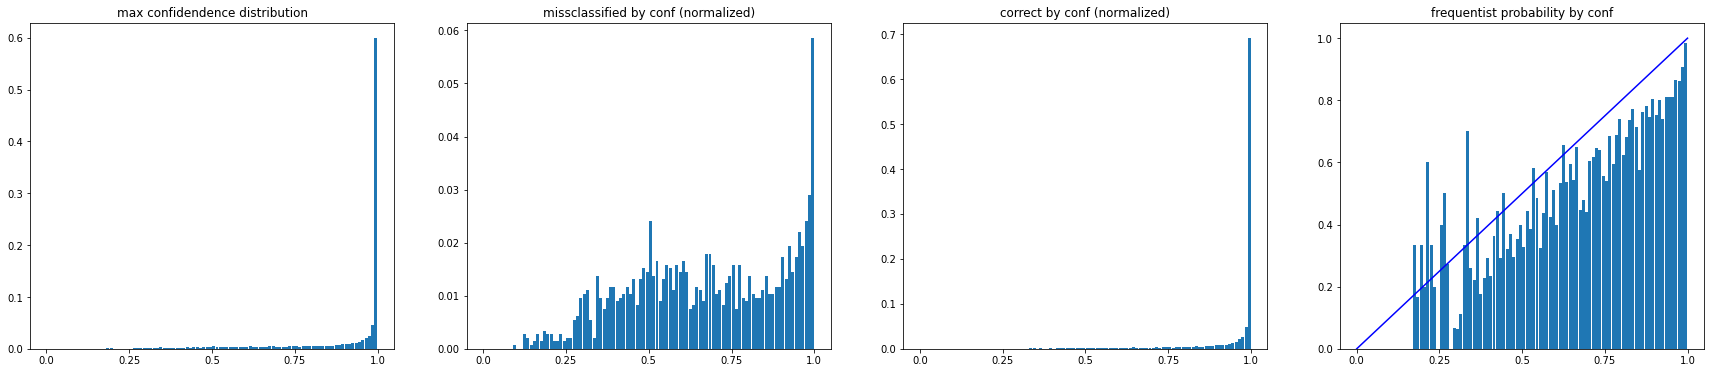

ECE_pred:  0.1288446282938625
ECE:  0.27449906586284906  Brier Score:  0.21395429968833923
Max conf quantile


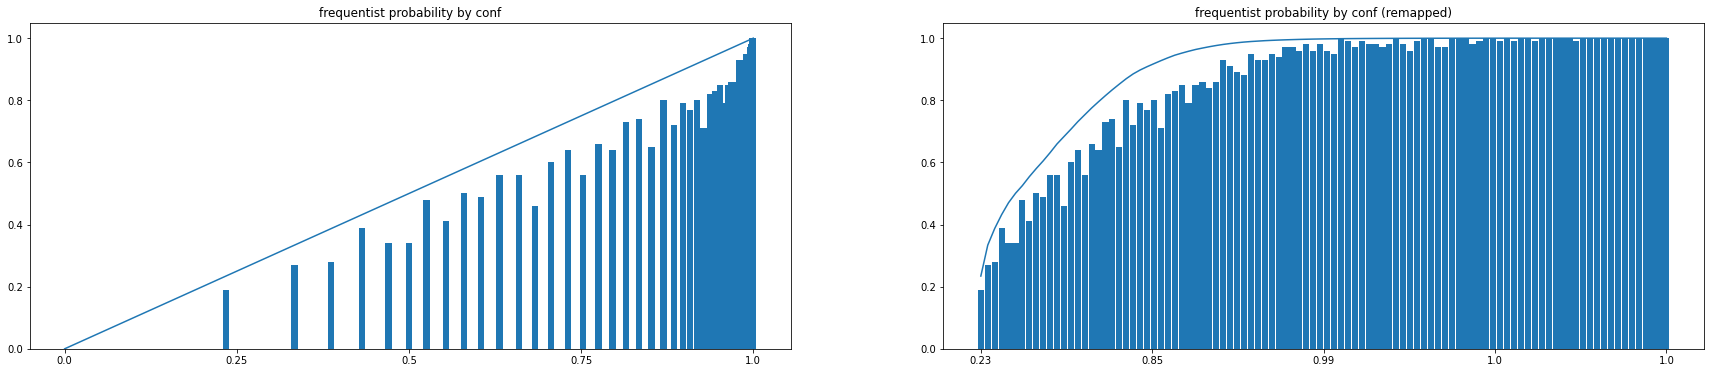

Quantile ECE_pred:  0.05318856239318848
Quantile ECE:  0.0012965325731784105


In [ ]:
#Betting TwoHeaded final epoch 60
trainer.load(60)
trainer.test(on="test")
trainer.prob_analysis()

Loaded:  ./BettingNetworksfinal/model_epoch60.pt
Version  BettingNetworksfinal


  0%|          | 0/157 [00:00<?, ?it/s]

Average test losses :
Book Loss: 0.0833	Bettor Loss: -0.0833	CEp: 0.5302	CEq: 0.5317	
Accuracy : 0.8605	Macro F1 Score : 0.8602	Macro Jaccard Score : 0.7630	Macro AUC ROC : 0.9973	
BettingNetworksfinal
Max confidence


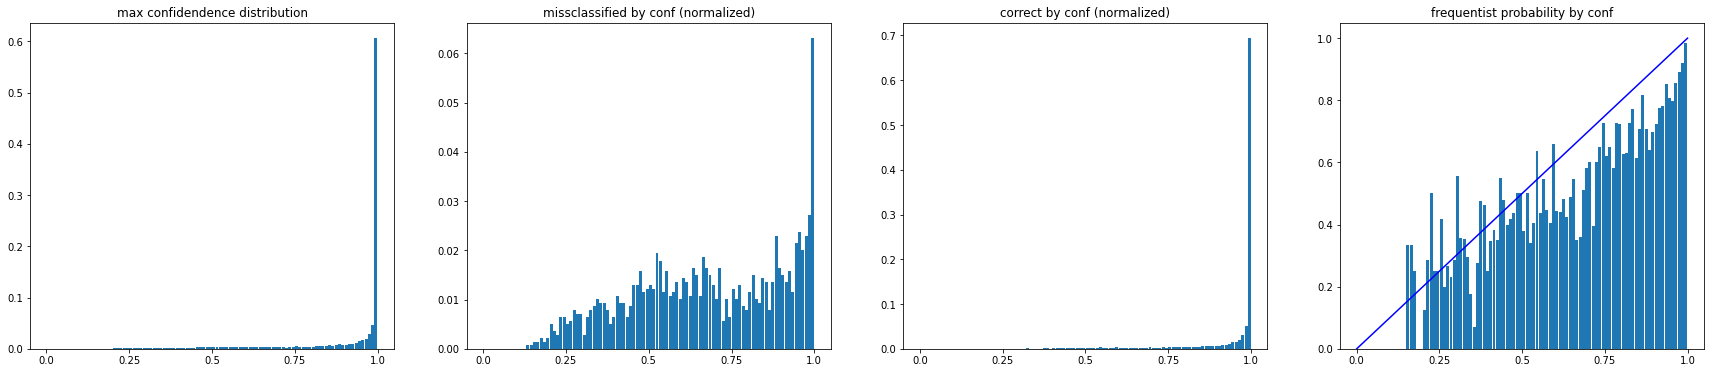

ECE_pred:  0.11878040919701259
ECE:  0.2746199885718497  Brier Score:  0.2075079381465912
Max conf quantile


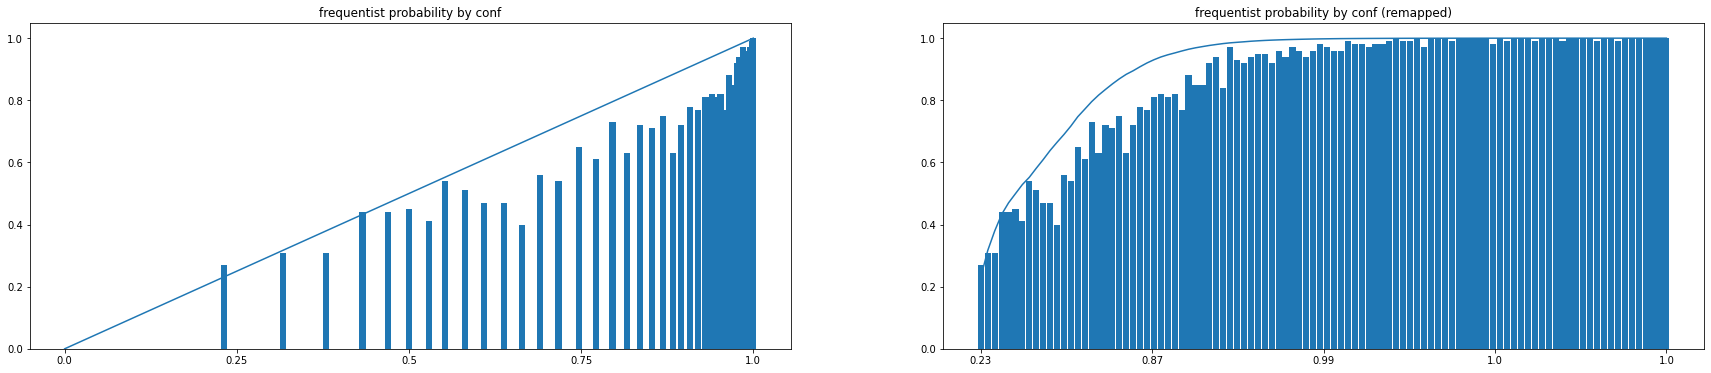

Quantile ECE_pred:  0.05110175162553787
Quantile ECE:  0.0012318509398028255


In [ ]:
#Betting final epoch 60
trainer.load(60)
trainer.test(on="test")
trainer.prob_analysis()

Loaded:  ./BaselineClassifierfinal/model_epoch60.pt
Version  BaselineClassifierfinal


  0%|          | 0/157 [00:00<?, ?it/s]

Average test losses :
CE: 0.5266	
Accuracy : 0.8522	Macro F1 Score : 0.8520	Macro Jaccard Score : 0.7502	Macro AUC ROC : 0.9974	
BaselineClassifierfinal
Max confidence


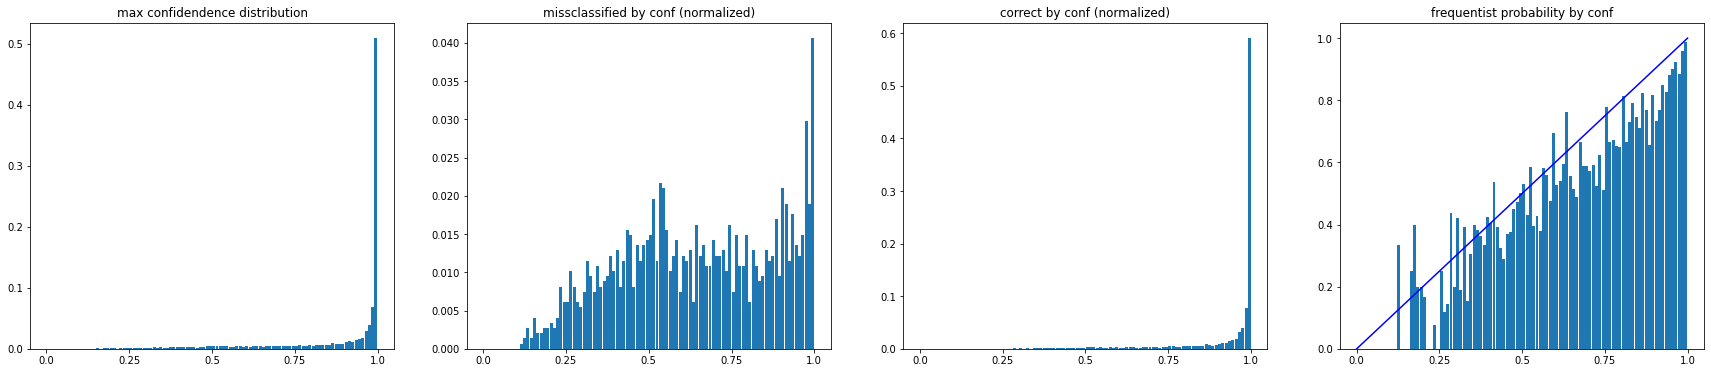

ECE_pred:  0.09751072688049144
ECE:  0.26652860283124985  Brier Score:  0.21615061163902283
Max conf quantile


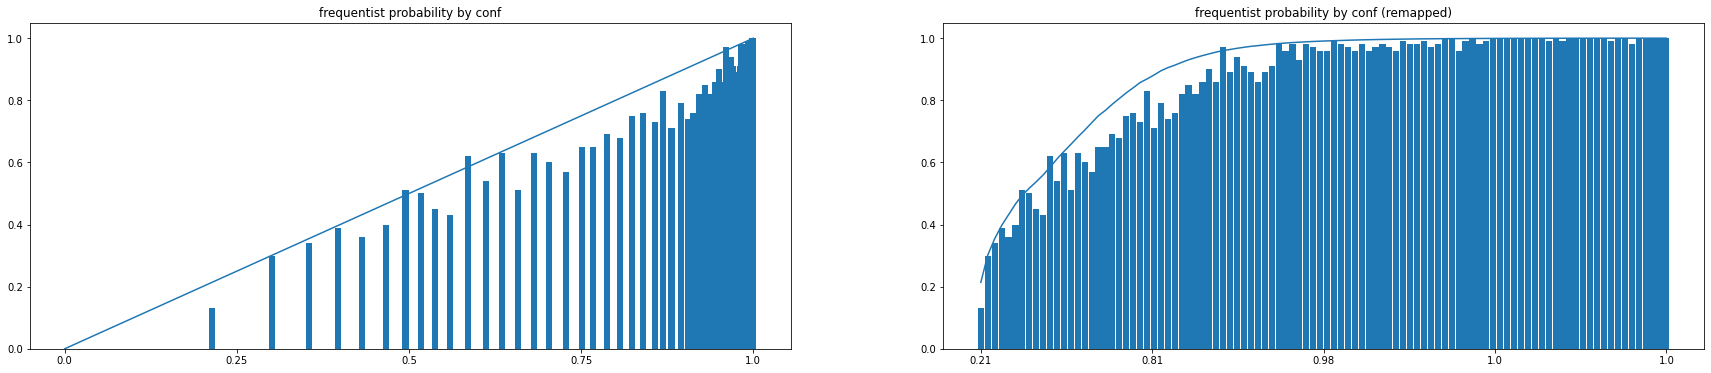

Quantile ECE_pred:  0.041176605969667435
Quantile ECE:  0.0012210460845381021


In [ ]:
#Baseline final epoch 60
trainer.load(60)
trainer.test(on="test")
trainer.prob_analysis()


Loaded:  ./BaselineClassifierfinal_nomomentum/model_epoch60.pt
Version  BaselineClassifierfinal_nomomentum


  0%|          | 0/157 [00:00<?, ?it/s]

Average test losses :
CE: 0.5553	
Accuracy : 0.8305	Macro F1 Score : 0.8299	Macro Jaccard Score : 0.7185	Macro AUC ROC : 0.9976	
BaselineClassifierfinal_nomomentum
Max confidence


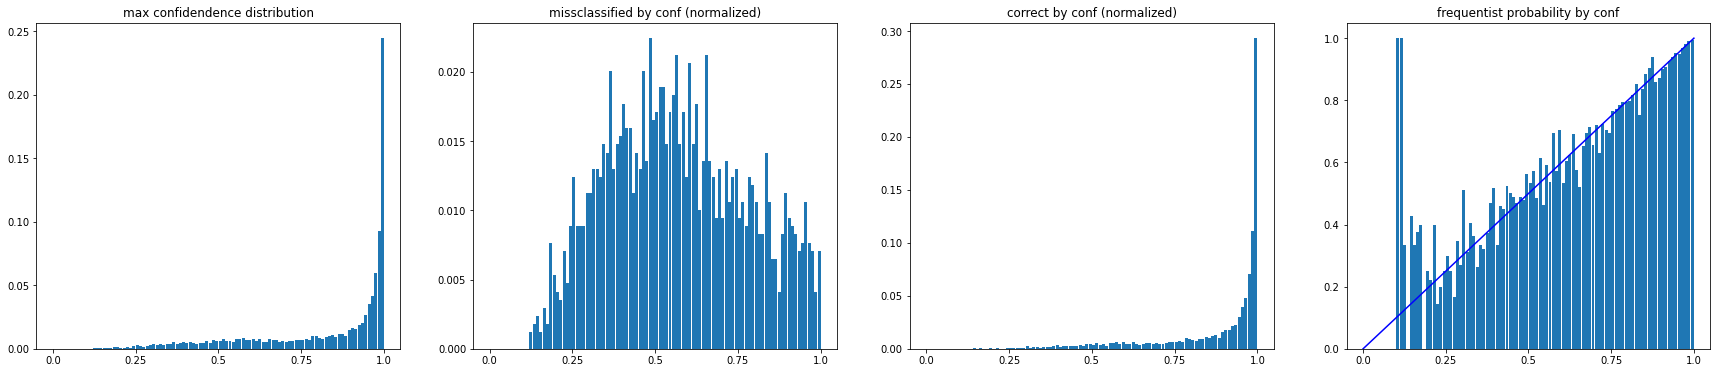

ECE_pred:  0.07275122548474204
ECE:  0.24618603041453072  Brier Score:  0.24199065566062927
Max conf quantile


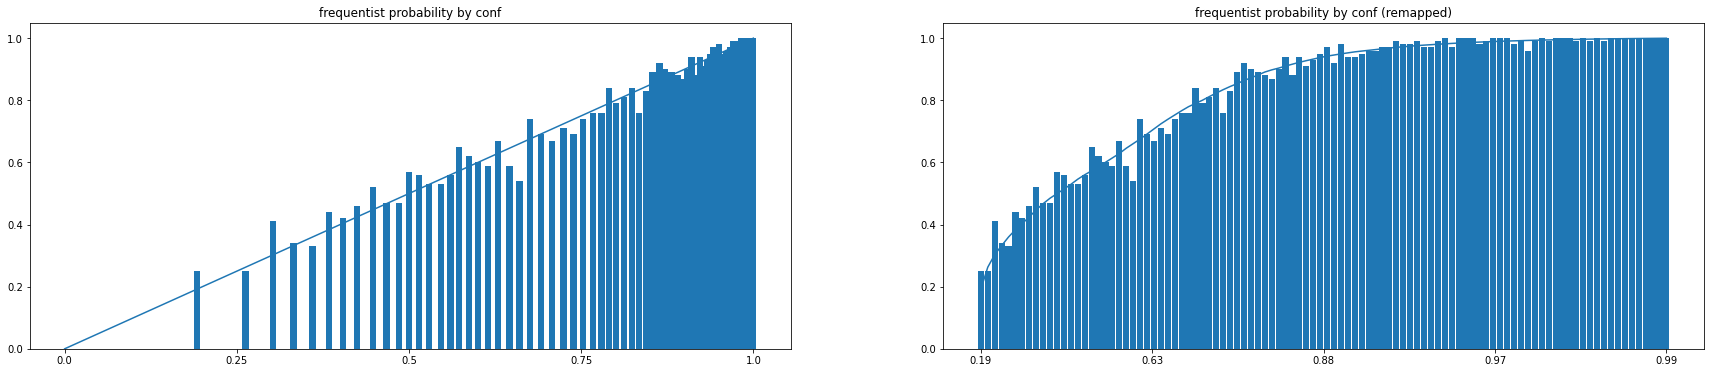

Quantile ECE_pred:  0.019913893193006516
Quantile ECE:  0.0011020670644938946


In [ ]:
#Baseline no momentum final epoch 60
trainer.load(60)
trainer.test(on="test")
trainer.prob_analysis()


Version  BettingNetworksTwoHeaded


  0%|          | 0/131 [00:00<?, ?it/s]

Average val losses :
Book Loss: -0.0067	Bettor Loss: 0.0067	CEp: 0.5535	CEq: 0.5683	
Accuracy : 0.8540	Macro F1 Score : 0.8529	Macro Jaccard Score : 0.7525	Macro AUC ROC : 0.9971	
BettingNetworksTwoHeaded
Max probs


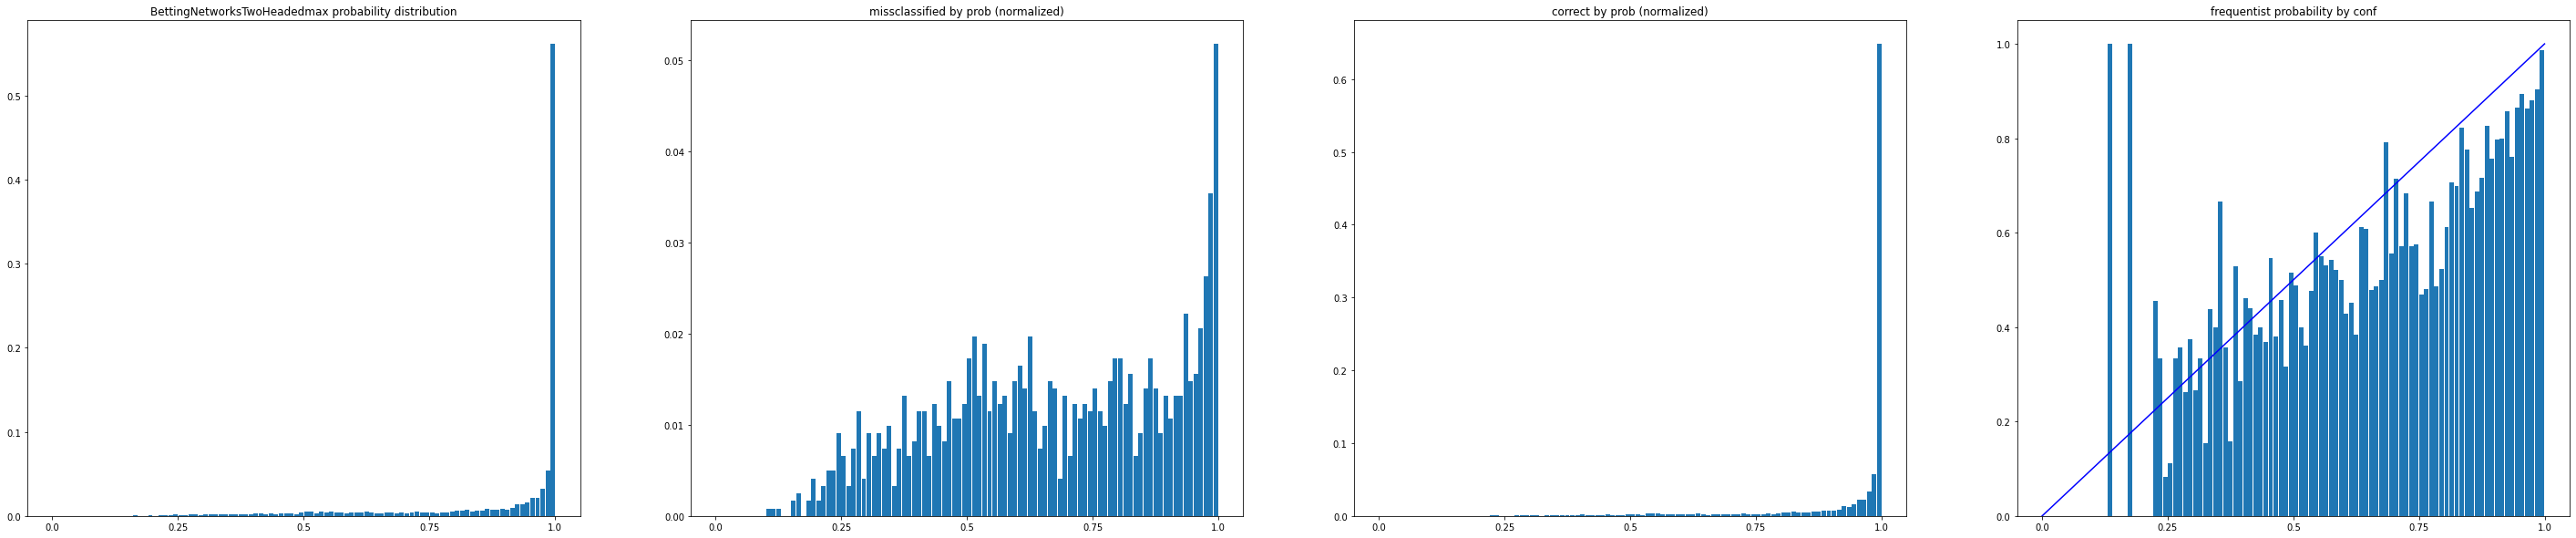

ECE_pred:  0.1326616245642137  Brier:  0.21910305321216583
ECE:  tensor(0.2661, dtype=torch.float64)


In [ ]:
trainer.test(on='val')
trainer.prob_analysis()



Version  BettingNetworks


  0%|          | 0/131 [00:00<?, ?it/s]

Average val losses :
Book Loss: 0.0783	Bettor Loss: -0.0783	CEp: 0.5728	CEq: 0.5768	
Accuracy : 0.8505	Macro F1 Score : 0.8498	Macro Jaccard Score : 0.7478	Macro AUC ROC : 0.9969	
BettingNetworks
Max probs


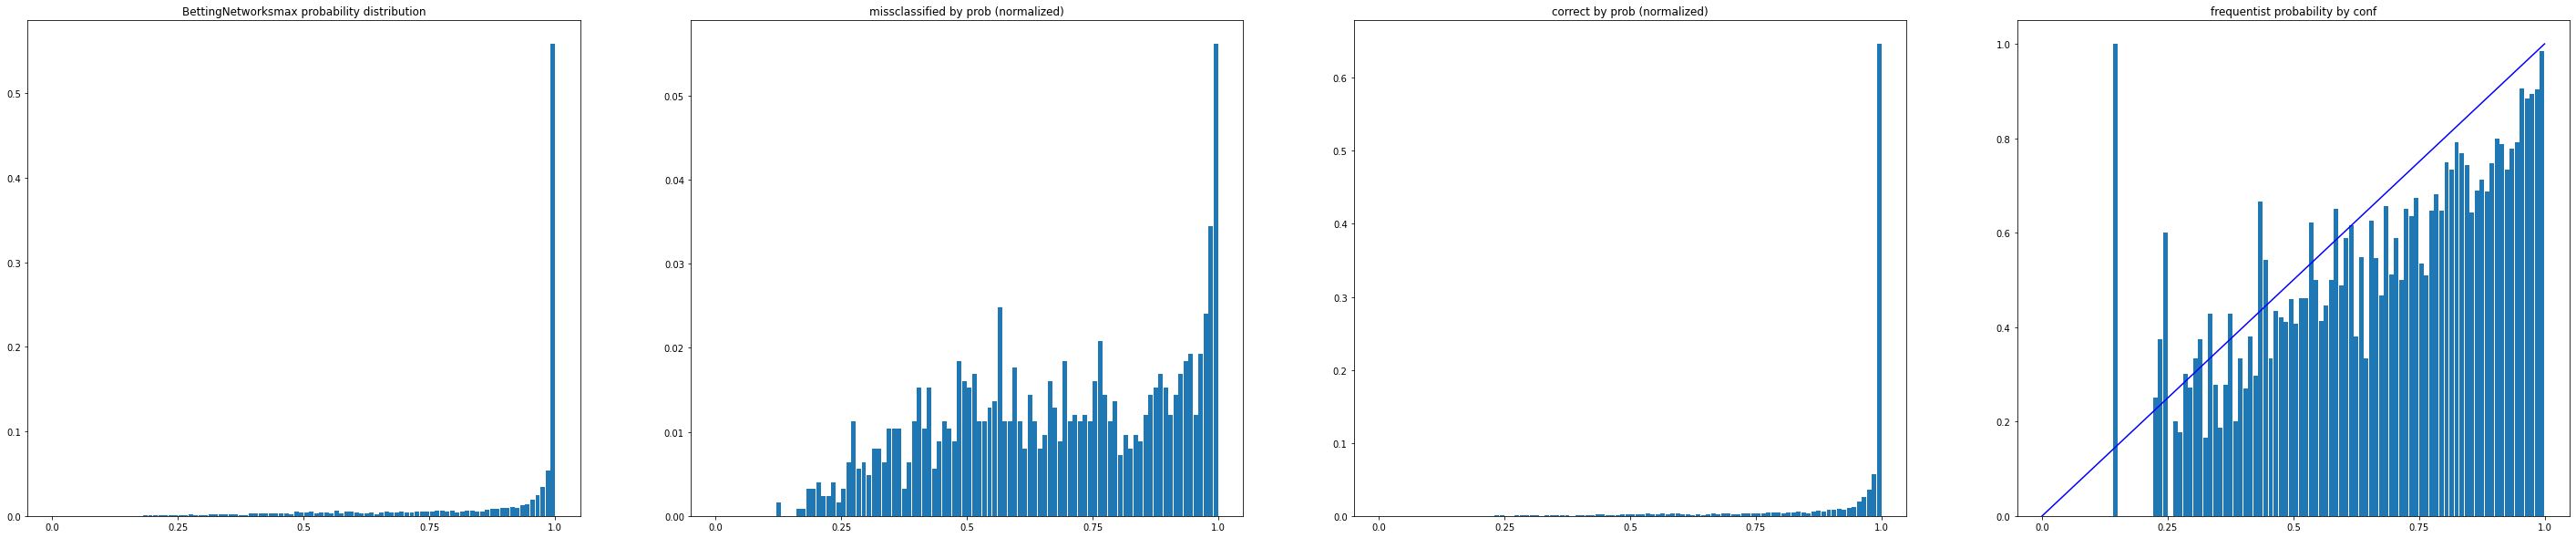

ECE_pred:  0.12547296928804974  Brier:  0.22428186237812042
ECE:  tensor(0.2682, dtype=torch.float64)


In [ ]:
#@title Analysis
trainer.test(on='val', prob='book')
trainer.prob_analysis()


Version  BaselineClassifier


  0%|          | 0/131 [00:00<?, ?it/s]

Average val losses :
CE: 0.5412	
Accuracy : 0.8423	Macro F1 Score : 0.8414	Macro Jaccard Score : 0.7358	Macro AUC ROC : 0.9974	
BaselineClassifier
Max probs


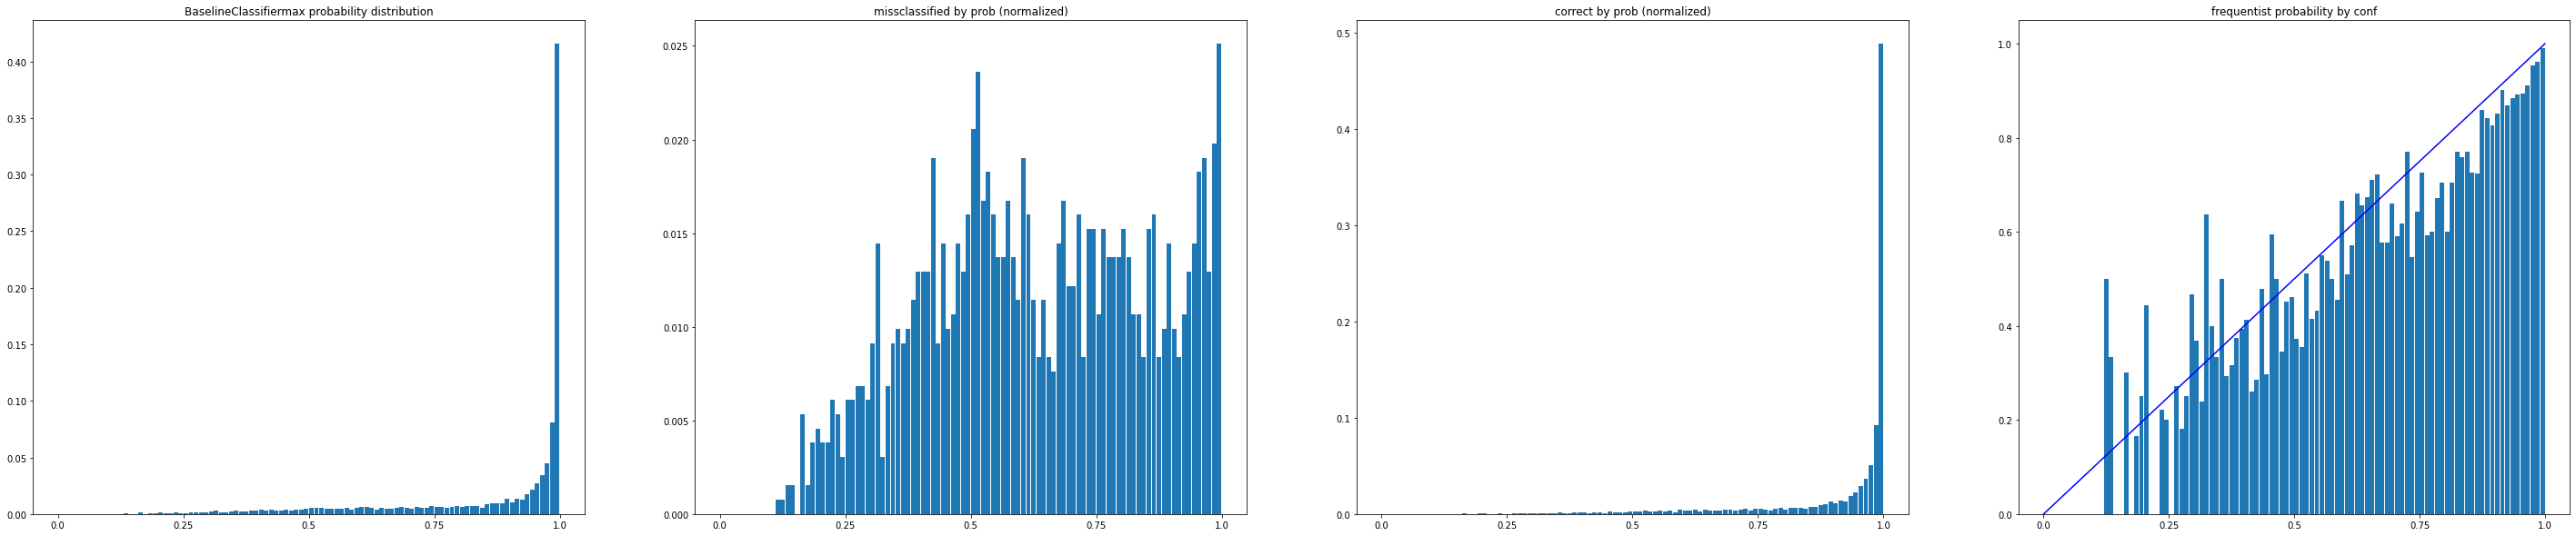

ECE_pred:  0.0918077433786609  Brier:  0.22796128690242767
ECE:  tensor(0.2567, dtype=torch.float64)


In [ ]:
#@title Analysis
trainer.test(on='val')
trainer.prob_analysis()

In [ ]:
#@title Baseline classifier hyperparameters optimization
trainer.save() #save initial setup
def objective(trial):
    trainer.load(0) 
    base_lr = trial.suggest_float("lr_init", 1e-3, 1e-1, log=True)
    print(f"New learning rate init = {base_lr}")
    lr = helper_lr(base_lr) # scales the learning rate proportionally
    trainer.update_learning_rate(lr)
    for step in range(10):
        trainer.train(1)
        intermediate_value = trainer.metrics['Accuracy']
        trial.report(intermediate_value, step) #only one check
        if trial.should_prune():
            raise optuna.TrialPruned()
    return trainer.metrics['Accuracy']

trainer.hypertuning_mode = True
study_name = 'tune_lr'  # Unique identifier of the study.
study = optuna.create_study(
                study_name=study_name,
                direction='maximize',
                pruner=optuna.pruners.MedianPruner(n_startup_trials=3,
                                                   n_warmup_steps=2))
study.optimize(objective, n_trials=10)

trial = study.best_trial

print('Accuracy: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

In [ ]:
np.zeros(10)